In [110]:
import sys
import random
import os
import numpy as np
import iisignature as iis
import matplotlib.pyplot as plt
import gudhi
from gudhi import plot_persistence_diagram
from gudhi import plot_persistence_density
from gtda.homology import VietorisRipsPersistence
from gtda.homology import FlagserPersistence
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import Amplitude
from gudhi.representations.vector_methods import Entropy
from gtda.diagrams import PairwiseDistance
from gtda.plotting import plot_diagram
import numpy.random as rd
import gudhi.representations
import random
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import mannwhitneyu
%run FUNCTIONS.ipynb

In [4]:
data_PS=generate_couple_map(20000,100,0.4, 1, 1.71, order=2)
ts_PS=np.zeros((10002,100))
for j in range(100):
    ts_PS[:,j]=data_PS[j][10000:]
    
    
data_CBMD=generate_couple_map(20000,100,0.1, 1, 1.85, order=2)
ts_CBMD=np.zeros((10002,100))
for j in range(100):
    ts_CBMD[:,j]=data_CBMD[j][10000:]
    
data_FDC=generate_couple_map(20000,100,0.3, 1, 2.00, order=2)
ts_FDC=np.zeros((10002,100))
for j in range(100):
    ts_FDC[:,j]=data_FDC[j][10000:]
    
data_STI=generate_couple_map(20000,100,0.6, 1, 1.75, order=2)
ts_STI=np.zeros((10002,100))
for j in range(100):
    ts_STI[:,j]=data_STI[j][10000:]
    
    
data_DT=generate_couple_map(20000,100,0.1, 1, 1.895, order=2)
ts_DT=np.zeros((10002,100))
for j in range(100):
    ts_DT[:,j]=data_DT[j][10000:]

In [98]:
np.save("ts_PS",ts_PS)
np.save("ts_DT",ts_DT)
np.save("ts_STI",ts_STI)
np.save("ts_FDC",ts_FDC)
np.save("ts_CBMD",ts_CBMD)

In [5]:
length=120

In [6]:
# Clique complex
# Entropy  curves

#no zscore
en_PS=en_1_vector(ts_PS,length) 
en_DT=en_1_vector(ts_DT,length)    
en_STI=en_1_vector(ts_STI,length)
en_FDC=en_1_vector(ts_FDC,length)
en_CBMD=en_1_vector(ts_CBMD,length)

# Z score
ts_PS_z=zscore(ts_PS,axis=0)
en_PS_z=en_1_vector(ts_PS_z,length) 
ts_DT_z=zscore(ts_DT,axis=0)
en_DT_z=en_1_vector(ts_DT_z,length)    
ts_STI_z=zscore(ts_STI,axis=0)
en_STI_z=en_1_vector(ts_STI_z,length)
ts_FDC_z=zscore(ts_FDC,axis=0)
en_FDC_z=en_1_vector(ts_FDC_z,length)
ts_CBMD_z=zscore(ts_CBMD,axis=0)
en_CBMD_z=en_1_vector(ts_CBMD_z,length)

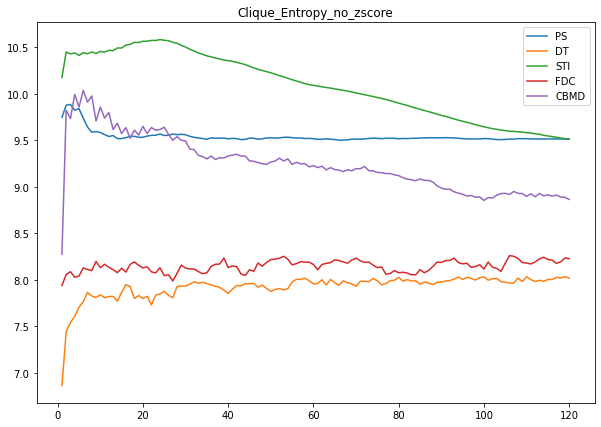

In [7]:
# Plot entropy no z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Clique_Entropy_no_zscore")
plt.plot(x,en_PS)
plt.plot(x,en_DT)
plt.plot(x,en_STI)
plt.plot(x,en_FDC)
plt.plot(x,en_CBMD)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Clique_Entropy_no_z_score.png")
plt.show()

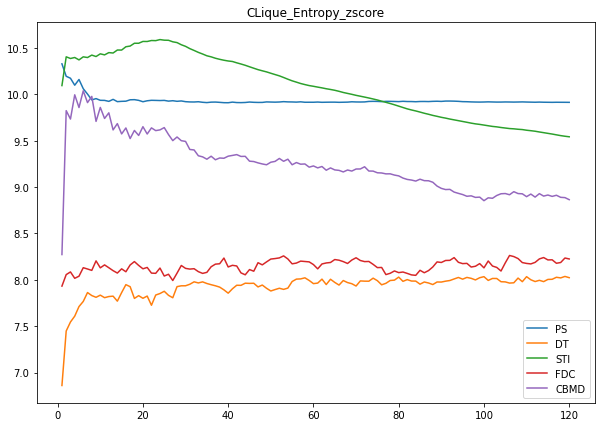

In [8]:
# Plot entropy z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("CLique_Entropy_zscore")
plt.plot(x,en_PS_z)
plt.plot(x,en_DT_z)
plt.plot(x,en_STI_z)
plt.plot(x,en_FDC_z)
plt.plot(x,en_CBMD_z)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Clique_Entropy_z_score.png")
plt.show()

In [9]:
# Amplitude  curves

#no zscore
am_PS=am_1_vector(ts_PS,length) 
am_DT=am_1_vector(ts_DT,length)   
am_STI=am_1_vector(ts_STI,length)
am_FDC=am_1_vector(ts_FDC,length)
am_CBMD=am_1_vector(ts_CBMD,length)

# z score
ts_PS_z=zscore(ts_PS,axis=0)
am_PS_z=am_1_vector(ts_PS_z,length) 
ts_DT_z=zscore(ts_DT,axis=0)
am_DT_z=am_1_vector(ts_DT_z,length)    
ts_STI_z=zscore(ts_STI,axis=0)
am_STI_z=am_1_vector(ts_STI_z,length)
ts_FDC_z=zscore(ts_FDC,axis=0)
am_FDC_z=am_1_vector(ts_FDC_z,length)
ts_CBMD_z=zscore(ts_CBMD,axis=0)
am_CBMD_z=am_1_vector(ts_CBMD_z,length)

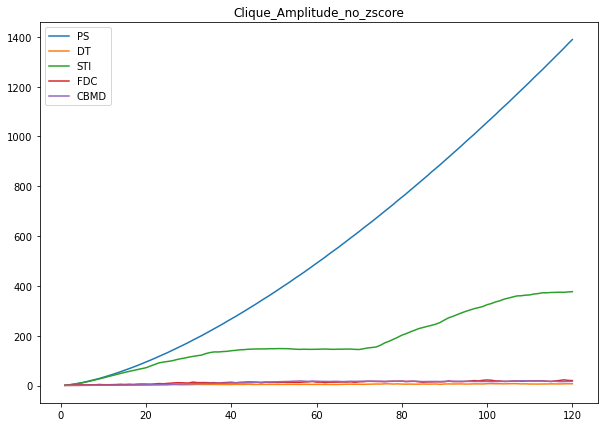

In [10]:
# Plot  amplitude no z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Clique_Amplitude_no_zscore")
plt.plot(x,am_PS)
plt.plot(x,am_DT)
plt.plot(x,am_STI)
plt.plot(x,am_FDC)
plt.plot(x,am_CBMD)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Clique_Amplitude_no_z_score.png")
plt.show()

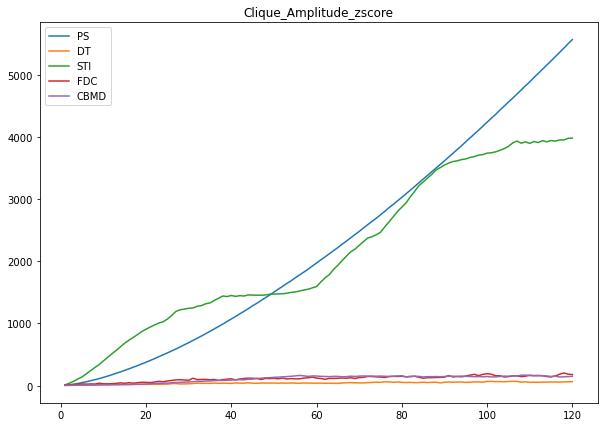

In [11]:
# Plot amplitude z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Clique_Amplitude_zscore")
plt.plot(x,am_PS_z)
plt.plot(x,am_DT_z)
plt.plot(x,am_STI_z)
plt.plot(x,am_FDC_z)
plt.plot(x,am_CBMD_z)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Clique_Amplitude_z_score.png")
plt.show()

In [40]:
def en_am_cl_sliding(time_series,number_intervals):
    l=time_series.shape[0]
    N=time_series.shape[1]
    h=np.int64(np.modf(l/number_intervals)[1])
    sub_h=np.int64(np.ceil(h/2))
    en_1_ts=[]
    am_1_ts=[]
    for i in range(1,number_intervals+1):
        sub_ts=time_series[(i*h-sub_h):(i*h+sub_h),:]
        L=lead_matrix_1(sub_ts)
        dgm_clique=rev_undirected(L)
        A=Amplitude()
        ampl_feat=A.fit_transform(dgm_clique)
        PE = PersistenceEntropy()
        pe_feat = PE.fit_transform(dgm_clique)
        en_1_ts.append(pe_feat[0,1])
        am_1_ts.append(ampl_feat[0,1])
    return en_1_ts, am_1_ts

In [41]:
length=120
indifference_value=0.05

#no zscore
en_PS_sl,am_PS_sl=en_am_cl_sliding(ts_PS,length) 
en_DT_sl,am_DT_sl=en_am_cl_sliding(ts_DT,length)   
en_STI_sl,am_STI_sl=en_am_cl_sliding(ts_STI,length)
en_FDC_sl,am_FDC_sl=en_am_cl_sliding(ts_FDC,length)
en_CBMD_sl,am_CBMD_sl=en_am_cl_sliding(ts_CBMD,length)

# z score
ts_PS_z=zscore(ts_PS,axis=0)
en_PS_z_sl,am_PS_z_sl=en_am_cl_sliding(ts_PS_z,length) 
ts_DT_z=zscore(ts_DT,axis=0)
en_DT_z_sl,am_DT_z_sl=en_am_cl_sliding(ts_DT_z,length)    
ts_STI_z=zscore(ts_STI,axis=0)
en_STI_z_sl,am_STI_z_sl=en_am_cl_sliding(ts_STI_z,length)
ts_FDC_z=zscore(ts_FDC,axis=0)
en_FDC_z_sl,am_FDC_z_sl=en_am_cl_sliding(ts_FDC_z,length)
ts_CBMD_z=zscore(ts_CBMD,axis=0)
en_CBMD_z_sl,am_CBMD_z_sl=en_am_cl_sliding(ts_CBMD_z,length)

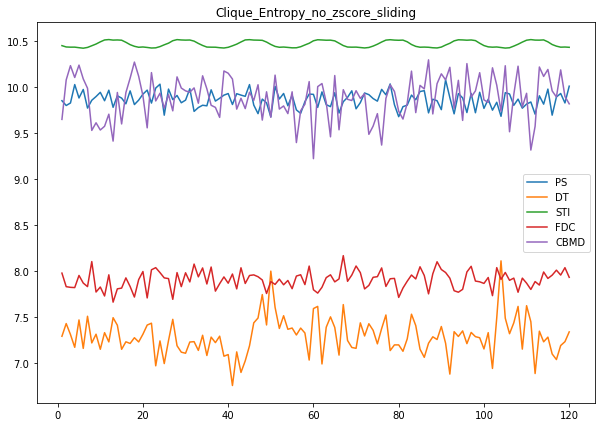

In [42]:
# Plot entropy no z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Clique_Entropy_no_zscore_sliding")
plt.plot(x,en_PS_sl)
plt.plot(x,en_DT_sl)
plt.plot(x,en_STI_sl)
plt.plot(x,en_FDC_sl)
plt.plot(x,en_CBMD_sl)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Clique_Entropy_sliding_no_z_score.png")
plt.show()

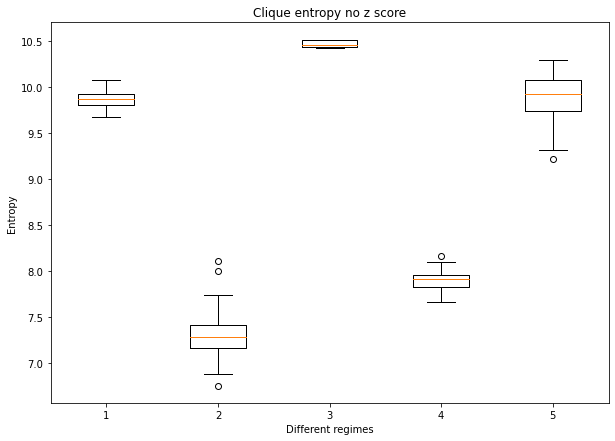

In [161]:
entropy_cl=[en_PS_sl,en_DT_sl,en_STI_sl,en_FDC_sl,en_CBMD_sl]
fig = plt.figure(figsize =(10, 7))
plt.title("Clique entropy no z score")
plt.ylabel("Entropy")
plt.xlabel("Different regimes")
plt.boxplot(entropy_cl)
plt.savefig("Box_plot_cl_entropy_noz_score.png")
plt.show()

In [160]:

# Anova
f_stat_an, p_an = stats.f_oneway(en_PS_sl,en_DT_sl,en_STI_sl,en_FDC_sl,en_CBMD_sl)
print(p_an)



# Kruskal
stat_k,p_k=stats.kruskal(en_PS_sl,en_DT_sl,en_STI_sl,en_FDC_sl,en_CBMD_sl)
print(p_k)


# Komologrov smirnov sulle due più simili



#t_stat_t, p_t= stats.ttest_ind(en_PS_sl,en_DT_sl,en_STI_sl,en_FDC_sl,en_CBMD_sl)
#print(p_t)

#U1, p_mann = mannwhitneyu(en_PS_sl,en_DT_sl,en_STI_sl,en_FDC_sl,en_CBMD_sl, method="exact")
#print(p_mann)

0.0
1.2279275142188473e-116


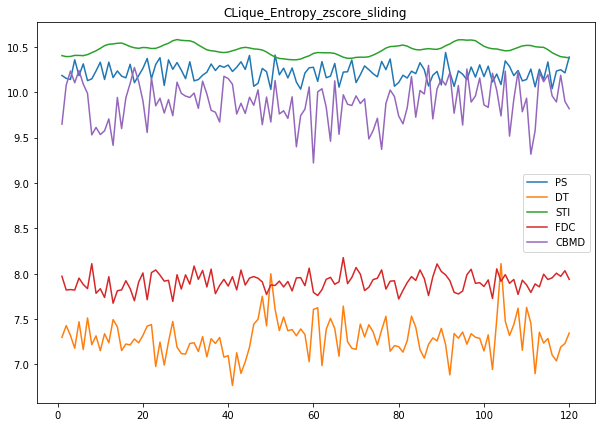

In [43]:
# Plot entropy z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("CLique_Entropy_zscore_sliding")
plt.plot(x,en_PS_z_sl)
plt.plot(x,en_DT_z_sl)
plt.plot(x,en_STI_z_sl)
plt.plot(x,en_FDC_z_sl)
plt.plot(x,en_CBMD_z_sl)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Clique_Entropy_z_score_sliding.png")
plt.show()

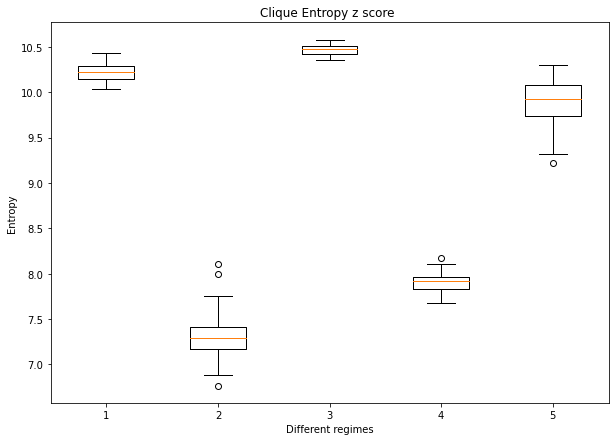

In [162]:
entropy_cl_z=[en_PS_z_sl,en_DT_z_sl,en_STI_z_sl,en_FDC_z_sl,en_CBMD_z_sl]
fig = plt.figure(figsize =(10, 7))
plt.title("Clique Entropy z score ")
plt.ylabel("Entropy")
plt.xlabel("Different regimes")
plt.boxplot(entropy_cl_z)
plt.savefig("Box_plot_cl_entropy_z_score.png")
plt.show()

In [159]:
f_stat_an, p_an = stats.f_oneway(en_PS_z_sl,en_DT_z_sl,en_STI_z_sl,en_FDC_z_sl,en_CBMD_z_sl)
print(p_an)



stat_k,p_k=stats.kruskal(en_PS_z_sl,en_DT_z_sl,en_STI_z_sl,en_FDC_z_sl,en_CBMD_z_sl)
print(p_k)

#t_stat_t, p_t= stats.ttest_ind(en_PS_z_sl,en_DT_z_sl,en_STI_z_sl,en_FDC_z_sl,en_CBMD_z_sl)
#print(p_t)

#U1, p_mann = mannwhitneyu(en_PS_z_sl,en_DT_z_sl,en_STI_z_sl,en_FDC_z_sl,en_CBMD_z_sl, method="exact")
#print(p_mann)

0.0
1.2333566767563626e-120


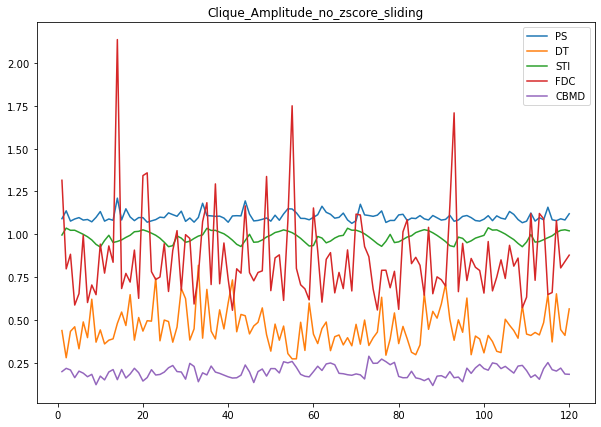

In [44]:
# Plot  amplitude no z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Clique_Amplitude_no_zscore_sliding")
plt.plot(x,am_PS_sl)
plt.plot(x,am_DT_sl)
plt.plot(x,am_STI_sl)
plt.plot(x,am_FDC_sl)
plt.plot(x,am_CBMD_sl)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Clique_Amplitude_no_z_score_sliding.png")
plt.show()

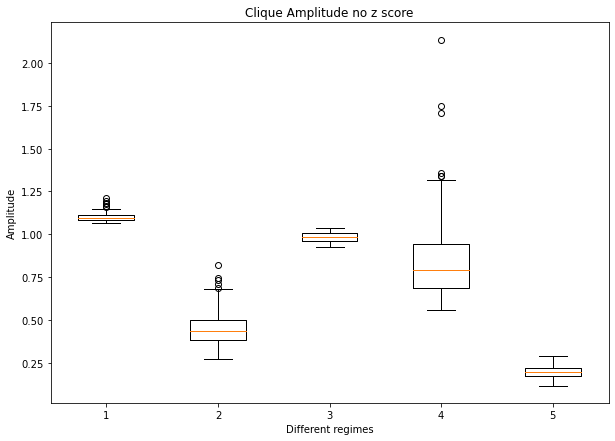

In [163]:
ampl_cl=[am_PS_sl,am_DT_sl,am_STI_sl,am_FDC_sl,am_CBMD_sl]
fig = plt.figure(figsize =(10, 7))
plt.title("Clique Amplitude no z score")
plt.ylabel("Amplitude")
plt.xlabel("Different regimes")
plt.boxplot(ampl_cl)
plt.savefig("Boxplot_cl_amplitude_no_zscore.png")
plt.show()

In [158]:
f_stat_an, p_an = stats.f_oneway(am_PS_sl,am_DT_sl,am_STI_sl,am_FDC_sl,am_CBMD_sl)
print(p_an)


stat_k,p_k=stats.kruskal(am_PS_sl,am_DT_sl,am_STI_sl,am_FDC_sl,am_CBMD_sl)
print(p_k)

#t_stat_t, p_t= stats.ttest_ind(am_PS_sl,am_DT_sl,am_STI_sl,am_FDC_sl,am_CBMD_sl)
#print(p_t)

#U1, p_mann = mannwhitneyu(am_PS_sl,am_DT_sl,am_STI_sl,am_FDC_sl,am_CBMD_sl, method="exact")
#print(p_mann)

5.799170114525148e-277
1.7204072620667785e-112


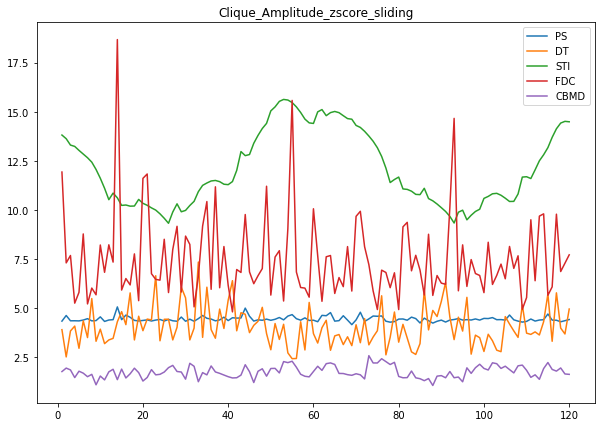

In [45]:
# Plot amplitude z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Clique_Amplitude_zscore_sliding")
plt.plot(x,am_PS_z_sl)
plt.plot(x,am_DT_z_sl)
plt.plot(x,am_STI_z_sl)
plt.plot(x,am_FDC_z_sl)
plt.plot(x,am_CBMD_z_sl)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Clique_Amplitude_z_score_sliding.png")
plt.show()

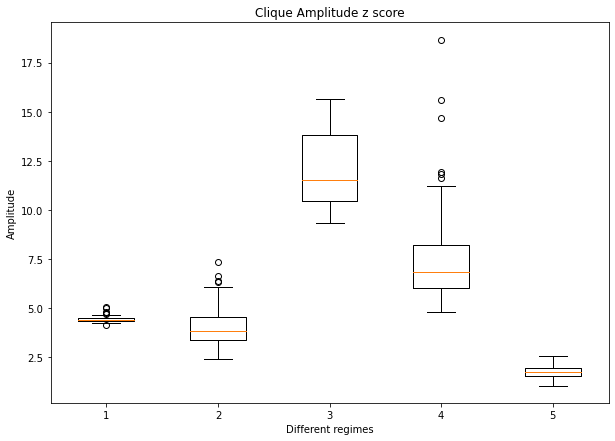

In [164]:
ampl_z_cl=[am_PS_z_sl,am_DT_z_sl,am_STI_z_sl,am_FDC_z_sl,am_CBMD_z_sl]
fig = plt.figure(figsize =(10, 7))
plt.title("Clique Amplitude z score")
plt.ylabel("Amplitude")
plt.xlabel("Different regimes")
plt.boxplot(ampl_z_cl)
plt.savefig("Boxplot_cl_amplitude_zscore.png")
plt.show()

In [157]:
f_stat_an, p_an = stats.f_oneway(am_PS_z_sl,am_DT_z_sl,am_STI_z_sl,am_FDC_z_sl,am_CBMD_z_sl)
print(p_an)


stat_k,p_k=stats.kruskal(am_PS_z_sl,am_DT_z_sl,am_STI_z_sl,am_FDC_z_sl,am_CBMD_z_sl)
print(p_k)

#t_stat_t, p_t= stats.ttest_ind(am_PS_z_sl,am_DT_z_sl,am_STI_z_sl,am_FDC_z_sl,am_CBMD_z_sl)
#print(p_t)

#U1, p_mann = mannwhitneyu(am_PS_z_sl,am_DT_z_sl,am_STI_z_sl,am_FDC_z_sl,am_CBMD_z_sl, method="exact")
#print(p_mann)

1.089469719016723e-265
1.5282305558845913e-115


In [ ]:
# Entropy high order


length=120
indifference_value=0.05

#no zscore
hyp_PS,en_1_PS,en_0_PS=en_h_hyp_v(ts_PS,length,indifference_value) 
hyp_DT,en_1_DT,en_0_DT=en_h_hyp_v(ts_DT,length,indifference_value)   
hyp_STI,en_1_STI,en_0_STI=en_h_hyp_v(ts_STI,length,indifference_value)
hyp_FDC,en_1_FDC,en_0_FDC=en_h_hyp_v(ts_FDC,length,indifference_value)
hyp_CBMD,en_1_CBMD,en_0_CBMD=en_h_hyp_v(ts_CBMD,length,indifference_value)

# z score
ts_PS_z=zscore(ts_PS,axis=0)
hyp_PS_z,en_1_PS_z,en_0_PS_z=en_h_hyp_v(ts_PS_z,length,indifference_value) 
ts_DT_z=zscore(ts_DT,axis=0)
hyp_DT_z,en_1_DT_z,en_0_DT_z=en_h_hyp_v(ts_DT_z,length,indifference_value)    
ts_STI_z=zscore(ts_STI,axis=0)
hyp_STI_z,en_1_STI_z,en_0_STI_z=en_h_hyp_v(ts_STI_z,length,indifference_value)
ts_FDC_z=zscore(ts_FDC,axis=0)
hyp_FDC_z,en_1_FDC_z,en_0_FDC_z=en_h_hyp_v(ts_FDC_z,length,indifference_value)
ts_CBMD_z=zscore(ts_CBMD,axis=0)
hyp_CBMD_z,en_1_CBMD_z,en_0_CBMD_z=en_h_hyp_v(ts_CBMD_z,length,indifference_value)

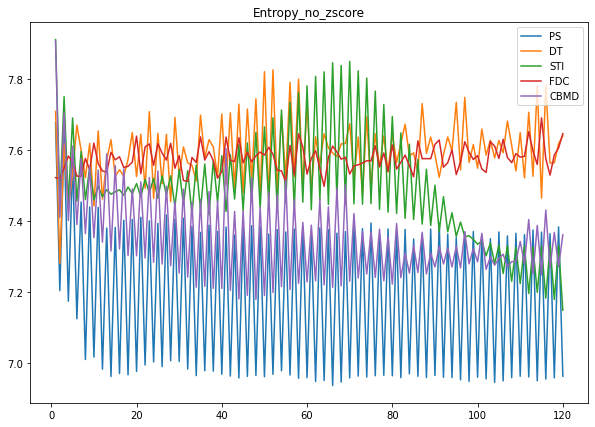

In [13]:
# Plot entropy high 1 no z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Entropy_no_zscore")
plt.plot(x,en_1_PS)
plt.plot(x,en_1_DT)
plt.plot(x,en_1_STI)
plt.plot(x,en_1_FDC)
plt.plot(x,en_1_CBMD)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Entropy_high_no_z_score.png")
plt.show()

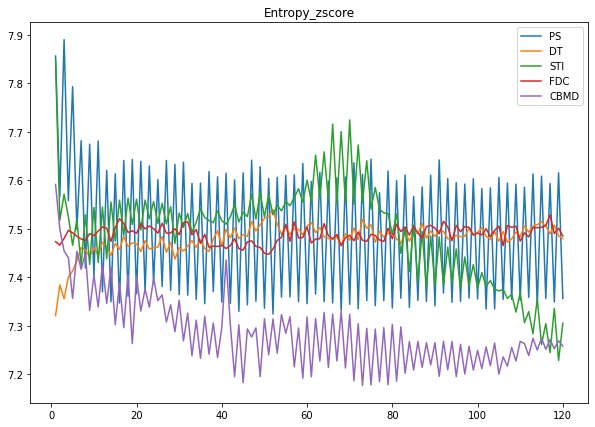

In [14]:
# Plot entropy 1 high z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Entropy_zscore")
plt.plot(x,en_1_PS_z)
plt.plot(x,en_1_DT_z)
plt.plot(x,en_1_STI_z)
plt.plot(x,en_1_FDC_z)
plt.plot(x,en_1_CBMD_z)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Entropy_high_z_score.png")
plt.show()

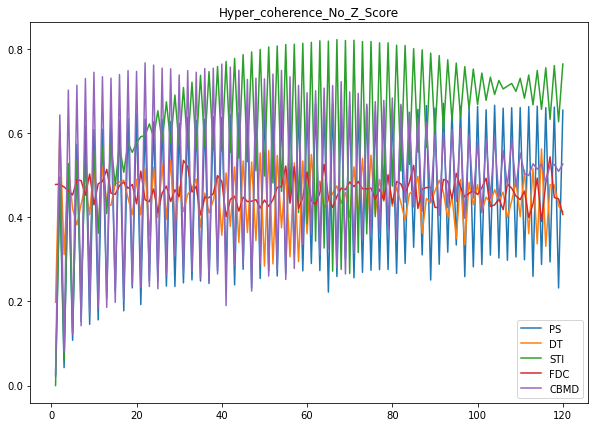

In [15]:
# plot hyper coherence no z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Hyper_coherence_No_Z_Score")
plt.plot(x,hyp_PS)
plt.plot(x,hyp_DT)
plt.plot(x,hyp_STI)
plt.plot(x,hyp_FDC)
plt.plot(x,hyp_CBMD)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Hyperocherence_no_zscore.png")
plt.show()

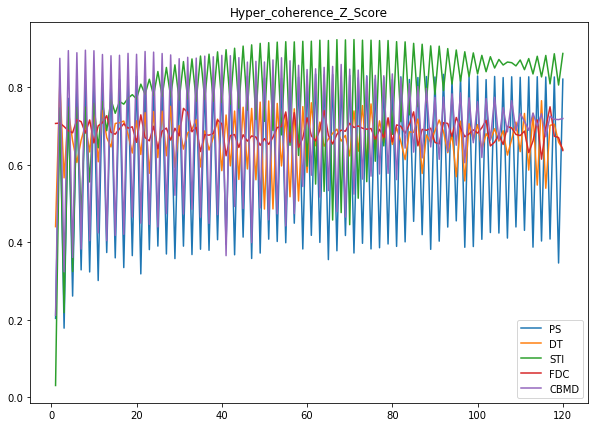

In [16]:
# plot hyper coherence zscore
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Hyper_coherence_Z_Score")
plt.plot(x,hyp_PS_z)
plt.plot(x,hyp_DT_z)
plt.plot(x,hyp_STI_z)
plt.plot(x,hyp_FDC_z)
plt.plot(x,hyp_CBMD_z)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Hyperocherence_Z_Score.png")
plt.show()

In [18]:
def violating_momentum(L,T,indifference_value):
    N=L.shape[0]
    for i in range(N):
        for j in range(N):
            if np.abs(L[i,j])<indifference_value:
                L[i,j]=0
            for k in range(N):
                if np.abs(T[i,j,k])<indifference_value:
                    T[i,j,k]=0
    
    
    
    total=0
    violating_momentum=0
    for i in range(N):
        for j in range(i,N):
            for k in range(j,N):
                if ((not (j==i)) and (not (i==k)) and (not (j==k))):
                    total=total+1
                    a=L[i,j]+L[j,k]+L[k,i]
                    b=T[i,j,k]
                    if np.abs(b)>np.abs(a):
                        violating_momentum=violating_momentum+1
    viol=violating_momentum/total
    return viol


def viol_ts(time_series,indifference_value):
    L,T=get_lead(time_series)
    viol=violating_momentum(L,T,indifference_value)
    return viol

def viol_v(time_series,length,indifference_value):
    viol_v=[]
    l=time_series.shape[0]
    N=time_series.shape[1]
    h=np.modf(l/length)[1]
    for i in range(1,length+1):
        sub_ts=time_series[:(np.int64(h)*i),:]
        viol=viol_ts(sub_ts,indifference_value)
        viol_v.append(viol)
    return viol_v
    

In [19]:
# parameters
length=120
indifference_value=0.05

#no zscore
viol_PS=viol_v(ts_PS,length,indifference_value) 
viol_DT=viol_v(ts_DT,length,indifference_value)   
viol_STI=viol_v(ts_STI,length,indifference_value)
viol_FDC=viol_v(ts_FDC,length,indifference_value)
viol_CBMD=viol_v(ts_CBMD,length,indifference_value)

# z score
ts_PS_z=zscore(ts_PS,axis=0)
viol_PS_z=viol_v(ts_PS_z,length,indifference_value) 
ts_DT_z=zscore(ts_DT,axis=0)
viol_DT_z=viol_v(ts_DT_z,length,indifference_value)    
ts_STI_z=zscore(ts_STI,axis=0)
viol_STI_z=viol_v(ts_STI_z,length,indifference_value)
ts_FDC_z=zscore(ts_FDC,axis=0)
viol_FDC_z=viol_v(ts_FDC_z,length,indifference_value)
ts_CBMD_z=zscore(ts_CBMD,axis=0)
viol_CBMD_z=viol_v(ts_CBMD_z,length,indifference_value)



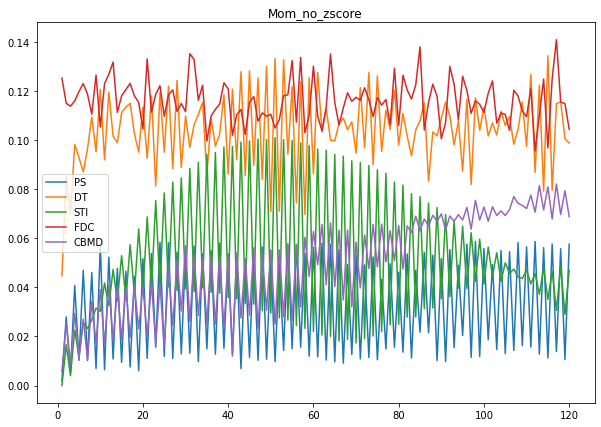

In [20]:
# Plot entropy high 1 no z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Mom_no_zscore")
plt.plot(x,viol_PS)
plt.plot(x,viol_DT)
plt.plot(x,viol_STI)
plt.plot(x,viol_FDC)
plt.plot(x,viol_CBMD)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Mom_high_no_z_score.png")
plt.show()

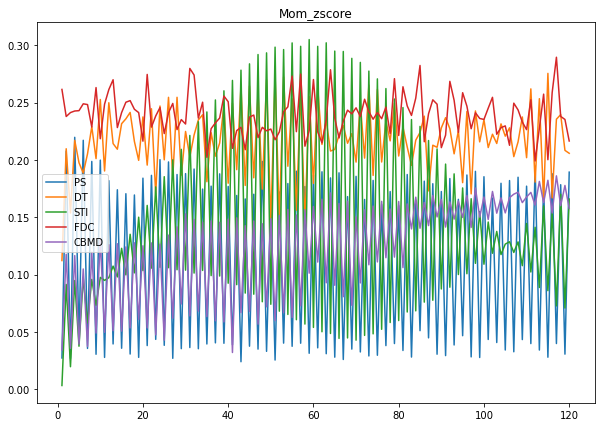

In [21]:
# Plot entropy high 1 no z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Mom_zscore")
plt.plot(x,viol_PS_z)
plt.plot(x,viol_DT_z)
plt.plot(x,viol_STI_z)
plt.plot(x,viol_FDC_z)
plt.plot(x,viol_CBMD_z)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Mom_zscore.png")
plt.show()

In [56]:
# Entropy Modified high order


length=120
indifference_value=0.05

#no zscore
hyp_PS_mod,en_1_PS_mod,en_0_PS_mod=en_h_hyp_v_mod(ts_PS,length,indifference_value) 
hyp_DT_mod,en_1_DT_mod,en_0_DT_mod=en_h_hyp_v_mod(ts_DT,length,indifference_value)   
hyp_STI_mod,en_1_STI_mod,en_0_STI_mod=en_h_hyp_v_mod(ts_STI,length,indifference_value)
hyp_FDC_mod,en_1_FDC_mod,en_0_FDC_mod=en_h_hyp_v_mod(ts_FDC,length,indifference_value)
hyp_CBMD_mod,en_1_CBMD_mod,en_0_CBMD_mod=en_h_hyp_v_mod(ts_CBMD,length,indifference_value)

# z score
ts_PS_z=zscore(ts_PS,axis=0)
hyp_PS_z_mod,en_1_PS_z_mod,en_0_PS_z_mod=en_h_hyp_v_mod(ts_PS_z,length,indifference_value) 
ts_DT_z=zscore(ts_DT,axis=0)
hyp_DT_z_mod,en_1_DT_z_mod,en_0_DT_z_mod=en_h_hyp_v_mod(ts_DT_z,length,indifference_value)    
ts_STI_z=zscore(ts_STI,axis=0)
hyp_STI_z_mod,en_1_STI_z_mod,en_0_STI_z_mod=en_h_hyp_v_mod(ts_STI_z,length,indifference_value)
ts_FDC_z=zscore(ts_FDC,axis=0)
hyp_FDC_z_mod,en_1_FDC_z_mod,en_0_FDC_z_mod=en_h_hyp_v_mod(ts_FDC_z,length,indifference_value)
ts_CBMD_z=zscore(ts_CBMD,axis=0)
hyp_CBMD_z_mod,en_1_CBMD_z_mod,en_0_CBMD_z_mod=en_h_hyp_v_mod(ts_CBMD_z,length,indifference_value)

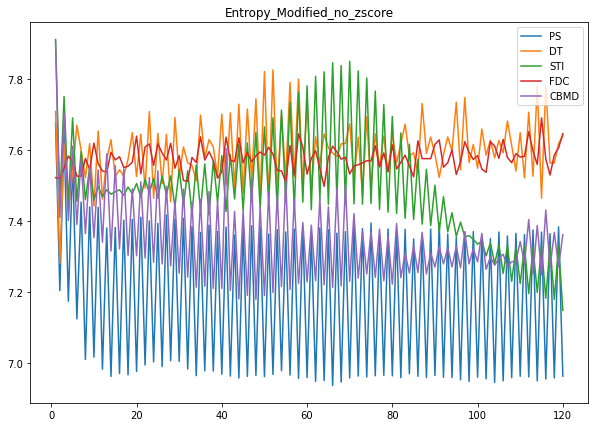

In [57]:
# Plot entropy Modified high 1 no z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Entropy_Modified_no_zscore")
plt.plot(x,en_1_PS_mod)
plt.plot(x,en_1_DT_mod)
plt.plot(x,en_1_STI_mod)
plt.plot(x,en_1_FDC_mod)
plt.plot(x,en_1_CBMD_mod)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Entropy_high_no_z_score.png")
plt.show()

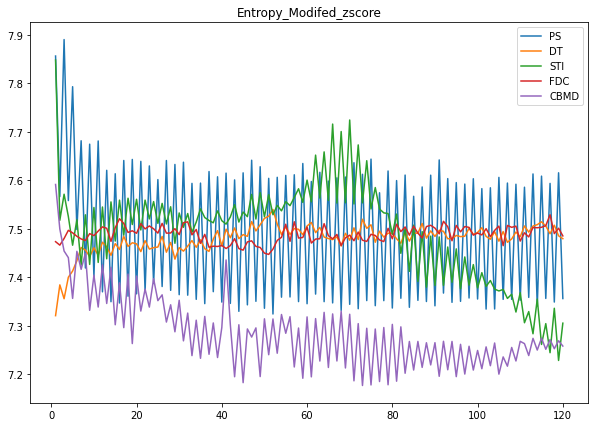

In [58]:
# Plot entropy 1  Modified high z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Entropy_Modifed_zscore")
plt.plot(x,en_1_PS_z_mod)
plt.plot(x,en_1_DT_z_mod)
plt.plot(x,en_1_STI_z_mod)
plt.plot(x,en_1_FDC_z_mod)
plt.plot(x,en_1_CBMD_z_mod)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Entropy_high_z_score.png")
plt.show()

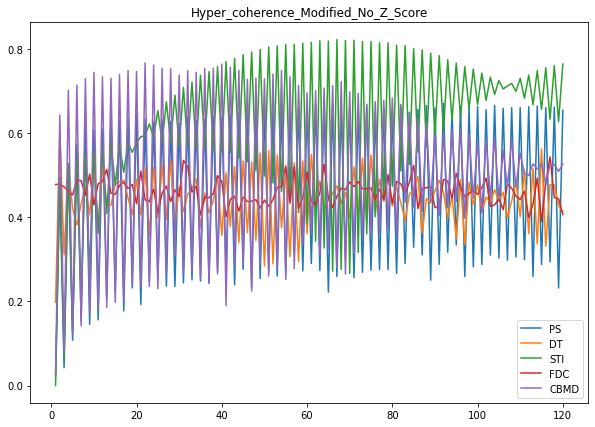

In [59]:
# plot hyper coherence Modified no z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Hyper_coherence_Modified_No_Z_Score")
plt.plot(x,hyp_PS_mod)
plt.plot(x,hyp_DT_mod)
plt.plot(x,hyp_STI_mod)
plt.plot(x,hyp_FDC_mod)
plt.plot(x,hyp_CBMD_mod)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Hyperocherence_Mod_no_zscore.png")
plt.show()

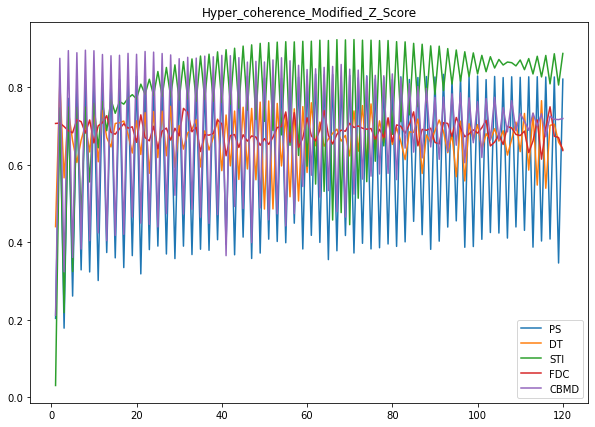

In [60]:
# plot hyper coherence  Modified zscore
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Hyper_coherence_Modified_Z_Score")
plt.plot(x,hyp_PS_z_mod)
plt.plot(x,hyp_DT_z_mod)
plt.plot(x,hyp_STI_z_mod)
plt.plot(x,hyp_FDC_z_mod)
plt.plot(x,hyp_CBMD_z_mod)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Hyperocherence_Mod_Z_Score.png")
plt.show()

In [27]:
def en_h_hyp_v_sliding(time_series,number_intervals,indifference_value):
    l=time_series.shape[0]
    N=time_series.shape[1]
    h=np.int64(np.modf(l/number_intervals)[1])
    sub_h=np.int64(np.ceil(h/2))
    en_0_ts=[]
    en_1_ts=[]
    hyp_ts=[]
    for i in range(1,number_intervals+1):
        sub_ts=time_series[(i*h-sub_h):(i*h+sub_h),:]
        dgm,hyp=create_diagram_directly_3(sub_ts,indifference_value)
        S_0,S_1=entropy_gu_ad(dgm)
        en_1_ts.append(S_1)
        hyp_ts.append(hyp)
        en_0_ts.append(S_0)
    return hyp_ts, en_1_ts, en_0_ts

In [28]:
# Sliding window




# Entropy high order


length=120
indifference_value=0.05

#no zscore
hyp_PS_sl,en_1_PS_sl,en_0_PS_sl=en_h_hyp_v_sliding(ts_PS,length,indifference_value) 
hyp_DT_sl,en_1_DT_sl,en_0_DT_sl=en_h_hyp_v_sliding(ts_DT,length,indifference_value)   
hyp_STI_sl,en_1_STI_sl,en_0_STI_sl=en_h_hyp_v_sliding(ts_STI,length,indifference_value)
hyp_FDC_sl,en_1_FDC_sl,en_0_FDC_sl=en_h_hyp_v_sliding(ts_FDC,length,indifference_value)
hyp_CBMD_sl,en_1_CBMD_sl,en_0_CBMD_sl=en_h_hyp_v_sliding(ts_CBMD,length,indifference_value)

# z score
ts_PS_z=zscore(ts_PS,axis=0)
hyp_PS_z_sl,en_1_PS_z_sl,en_0_PS_z_sl=en_h_hyp_v_sliding(ts_PS_z,length,indifference_value) 
ts_DT_z=zscore(ts_DT,axis=0)
hyp_DT_z_sl,en_1_DT_z_sl,en_0_DT_z_sl=en_h_hyp_v_sliding(ts_DT_z,length,indifference_value)    
ts_STI_z=zscore(ts_STI,axis=0)
hyp_STI_z_sl,en_1_STI_z_sl,en_0_STI_z_sl=en_h_hyp_v_sliding(ts_STI_z,length,indifference_value)
ts_FDC_z=zscore(ts_FDC,axis=0)
hyp_FDC_z_sl,en_1_FDC_z_sl,en_0_FDC_z_sl=en_h_hyp_v_sliding(ts_FDC_z,length,indifference_value)
ts_CBMD_z=zscore(ts_CBMD,axis=0)
hyp_CBMD_z_sl,en_1_CBMD_z_sl,en_0_CBMD_z_sl=en_h_hyp_v_sliding(ts_CBMD_z,length,indifference_value)

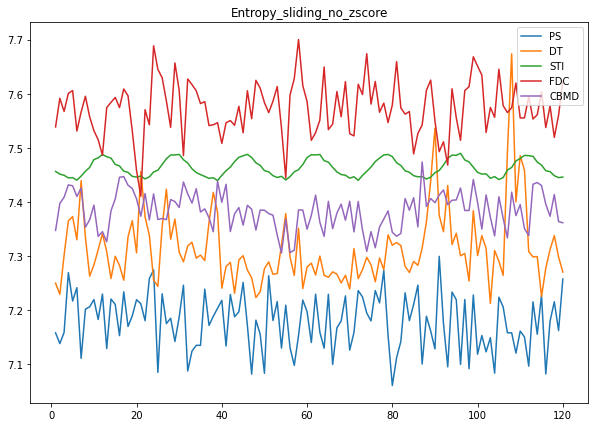

In [29]:
# Plot entropy Modified high 1 no z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Entropy_sliding_no_zscore")
plt.plot(x,en_1_PS_sl)
plt.plot(x,en_1_DT_sl)
plt.plot(x,en_1_STI_sl)
plt.plot(x,en_1_FDC_sl)
plt.plot(x,en_1_CBMD_sl)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Entropy_high_no_sliding_z_score.png")
plt.show()

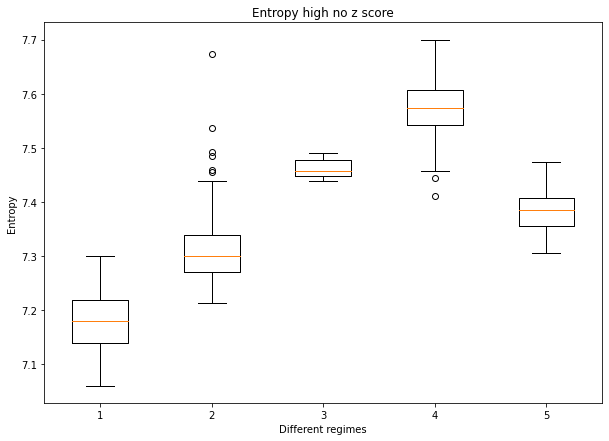

In [165]:
en_1_high=[en_1_PS_sl,en_1_DT_sl,en_1_STI_sl,en_1_FDC_sl,en_1_CBMD_sl]
fig = plt.figure(figsize =(10, 7))
plt.title("Entropy high no z score")
plt.ylabel("Entropy")
plt.xlabel("Different regimes")
plt.boxplot(en_1_high)
plt.savefig("Boxplot_entropy_high_no_zscore.png")
plt.show()

In [156]:
f_stat_an, p_an = stats.f_oneway(en_1_PS_sl,en_1_DT_sl,en_1_STI_sl,en_1_FDC_sl,en_1_CBMD_sl)
print(p_an)


stat_k,p_k=stats.kruskal(en_1_PS_sl,en_1_DT_sl,en_1_STI_sl,en_1_FDC_sl,en_1_CBMD_sl)
print(p_k)
#t_stat_t, p_t= stats.ttest_ind(en_1_PS_sl,en_1_DT_sl,en_1_STI_sl,en_1_FDC_sl,en_1_CBMD_sl)
#print(p_t)

#U1, p_mann = mannwhitneyu(en_1_PS_sl,en_1_DT_sl,en_1_STI_sl,en_1_FDC_sl,en_1_CBMD_sl, method="exact")
#print(p_mann)

9.119323694297214e-282
7.750353364235837e-116


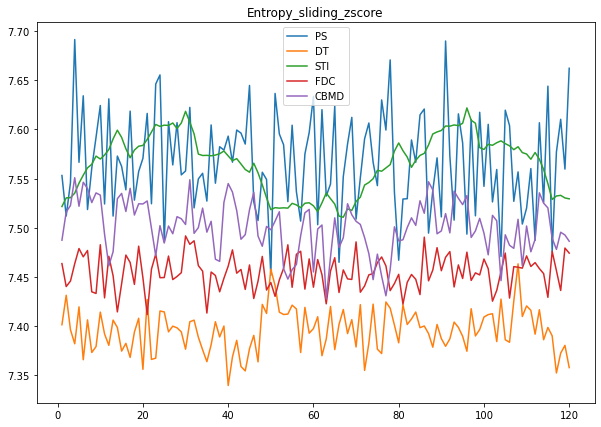

In [30]:
# Plot entropy 1  Modified high z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Entropy_sliding_zscore")
plt.plot(x,en_1_PS_z_sl)
plt.plot(x,en_1_DT_z_sl)
plt.plot(x,en_1_STI_z_sl)
plt.plot(x,en_1_FDC_z_sl)
plt.plot(x,en_1_CBMD_z_sl)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Entropy_high_sliding_z_score.png")
plt.show()

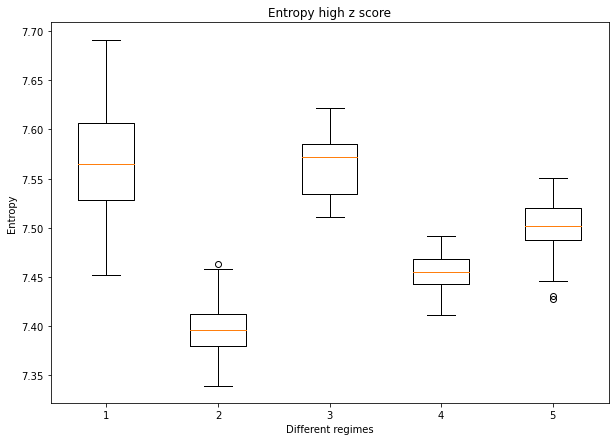

In [166]:
en_1_high_z=[en_1_PS_z_sl,en_1_DT_z_sl,en_1_STI_z_sl,en_1_FDC_z_sl,en_1_CBMD_z_sl]
fig = plt.figure(figsize =(10, 7))
plt.title("Entropy high z score")
plt.ylabel("Entropy")
plt.xlabel("Different regimes")
plt.boxplot(en_1_high_z)
plt.savefig("Boxplot_entropy_high_zscore.png")
plt.show()

In [155]:
f_stat_an, p_an = stats.f_oneway(en_1_PS_z_sl,en_1_DT_z_sl,en_1_STI_z_sl,en_1_FDC_z_sl,en_1_CBMD_z_sl)
print(p_an)

stat_k,p_k=stats.kruskal(en_1_PS_z_sl,en_1_DT_z_sl,en_1_STI_z_sl,en_1_FDC_z_sl,en_1_CBMD_z_sl)
print(p_k)


#t_stat_t, p_t= stats.ttest_ind(en_1_PS_z_sl,en_1_DT_z_sl,en_1_STI_z_sl,en_1_FDC_z_sl,en_1_CBMD_z_sl)
#print(p_t)

#U1, p_mann = mannwhitneyu(en_1_PS_z_sl,en_1_DT_z_sl,en_1_STI_z_sl,en_1_FDC_z_sl,en_1_CBMD_z_sl, method="exact")
#print(p_mann)

6.239521151480312e-219
2.0418431961410152e-107


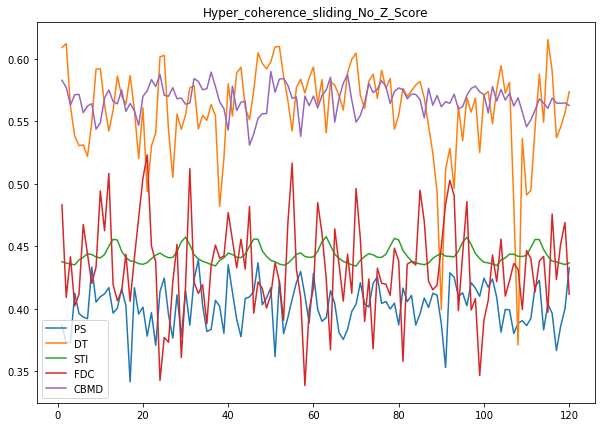

In [31]:
# plot hyper coherence Modified no z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Hyper_coherence_sliding_No_Z_Score")
plt.plot(x,hyp_PS_sl)
plt.plot(x,hyp_DT_sl)
plt.plot(x,hyp_STI_sl)
plt.plot(x,hyp_FDC_sl)
plt.plot(x,hyp_CBMD_sl)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Hyperocherence_sliding_no_zscore.png")
plt.show()

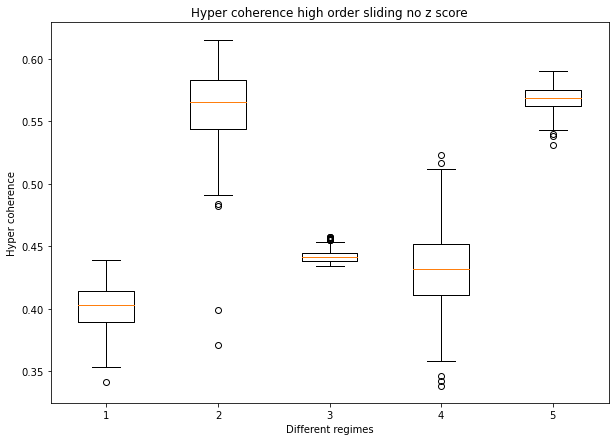

In [167]:
hyp_high=[hyp_PS_sl,hyp_DT_sl,hyp_STI_sl,hyp_FDC_sl,hyp_CBMD_sl]
fig = plt.figure(figsize =(10, 7))
plt.title("Hyper coherence high order sliding no z score")
plt.ylabel("Hyper coherence")
plt.xlabel("Different regimes")
plt.boxplot(hyp_high)
plt.savefig("Boxplot_hypercoh_no_zscore.png")
plt.show()

In [154]:
f_stat_an, p_an = stats.f_oneway(hyp_PS_sl,hyp_DT_sl,hyp_STI_sl,hyp_FDC_sl,hyp_CBMD_sl)
print(p_an)



stat_k,p_k=stats.kruskal(hyp_PS_sl,hyp_DT_sl,hyp_STI_sl,hyp_FDC_sl,hyp_CBMD_sl)
print(p_k)

#t_stat_t, p_t= stats.ttest_ind(hyp_PS_sl,hyp_DT_sl,hyp_STI_sl,hyp_FDC_sl,hyp_CBMD_sl)
#print(p_t)

#U1, p_mann = mannwhitneyu(hyp_PS_sl,hyp_DT_sl,hyp_STI_sl,hyp_FDC_sl,hyp_CBMD_sl, method="exact")
#print(p_mann)

3.928757380998794e-273
4.2341167669569745e-102


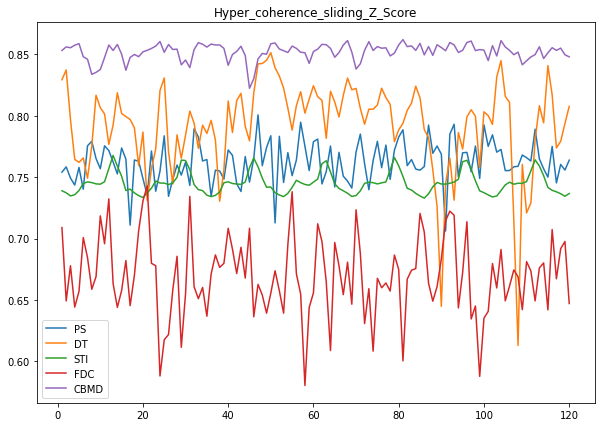

In [32]:
# plot hyper coherence  Modified zscore
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Hyper_coherence_sliding_Z_Score")
plt.plot(x,hyp_PS_z_sl)
plt.plot(x,hyp_DT_z_sl)
plt.plot(x,hyp_STI_z_sl)
plt.plot(x,hyp_FDC_z_sl)
plt.plot(x,hyp_CBMD_z_sl)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Hyperocherence_slising_Z_Score.png")
plt.show()

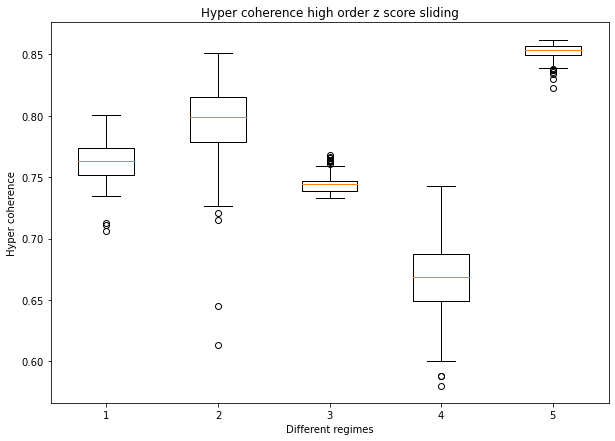

In [168]:
hyp_high_z=[hyp_PS_z_sl,hyp_DT_z_sl,hyp_STI_z_sl,hyp_FDC_z_sl,hyp_CBMD_z_sl]
fig = plt.figure(figsize =(10, 7))
plt.title("Hyper coherence high order z score sliding")
plt.ylabel("Hyper coherence")
plt.xlabel("Different regimes")
plt.boxplot(hyp_high_z)
plt.savefig("Box_plot_hypercoh_high_zscore.png")
plt.show()

In [153]:
f_stat_an, p_an = stats.f_oneway(hyp_PS_z_sl,hyp_DT_z_sl,hyp_STI_z_sl,hyp_FDC_z_sl,hyp_CBMD_z_sl)
print(p_an)


stat_k,p_k=stats.kruskal(hyp_PS_z_sl,hyp_DT_z_sl,hyp_STI_z_sl,hyp_FDC_z_sl,hyp_CBMD_z_sl)
print(p_k)

#t_stat_t, p_t= stats.ttest_ind(hyp_PS_z_sl,hyp_DT_z_sl,hyp_STI_z_sl,hyp_FDC_z_sl,hyp_CBMD_z_sl)
#print(p_t)

#U1, p_mann = mannwhitneyu(hyp_PS_z_sl,hyp_DT_z_sl,hyp_STI_z_sl,hyp_FDC_z_sl,hyp_CBMD_z_sl, method="exact")
#print(p_mann)

3.651306530750067e-261
5.096626436717854e-110


In [33]:
def violating_momentum(L,T,indifference_value):
    
    N=L.shape[0]
    for i in range(N):
        for j in range(N):
            if np.abs(L[i,j])<indifference_value:
                L[i,j]=0
            for k in range(N):
                if np.abs(T[i,j,k])<indifference_value:
                    T[i,j,k]=0
    total=0
    violating_momentum=0
    for i in range(N):
        for j in range(i,N):
            for k in range(j,N):
                if ((not (j==i)) and (not (i==k)) and (not (j==k))):
                    total=total+1
                    a=L[i,j]+L[j,k]+L[k,i]
                    b=T[i,j,k]
                    if np.abs(b)>np.abs(a):
                        violating_momentum=violating_momentum+1
    viol=violating_momentum/total
    return viol


def viol_ts(time_series,indifference_value):
    L,T=get_lead(time_series)
    viol=violating_momentum(L,T,indifference_value)
    return viol

def viol_v(time_series,length,indifference_value):
    viol_v=[]
    l=time_series.shape[0]
    N=time_series.shape[1]
    h=np.modf(l/length)[1]
    for i in range(1,length+1):
        sub_ts=time_series[:(np.int64(h)*i),:]
        viol=viol_ts(sub_ts,indifference_value)
        viol_v.append(viol)
    return viol_v




def viol_v_sliding(time_series,number_intervals,indifference_value):
    l=time_series.shape[0]
    N=time_series.shape[1]
    h=np.int64(np.modf(l/number_intervals)[1])
    sub_h=np.int64(np.ceil(h/2))
    viol_v=[]
    for i in range(1,number_intervals+1):
        sub_ts=time_series[(i*h-sub_h):(i*h+sub_h),:]
        viol=viol_ts(sub_ts,indifference_value)
        viol_v.append(viol)
    return viol_v

In [34]:
# SLIDING VIOL
# parameters
length=100
indifference_value=0.05

#no zscore
viol_PS_sl=viol_v_sliding(ts_PS,length,indifference_value) 
viol_DT_sl=viol_v_sliding(ts_DT,length,indifference_value)   
viol_STI_sl=viol_v_sliding(ts_STI,length,indifference_value)
viol_FDC_sl=viol_v_sliding(ts_FDC,length,indifference_value)
viol_CBMD_sl=viol_v_sliding(ts_CBMD,length,indifference_value)

# z score
ts_PS_z=zscore(ts_PS,axis=0)
viol_PS_z_sl=viol_v_sliding(ts_PS_z,length,indifference_value) 
ts_DT_z=zscore(ts_DT,axis=0)
viol_DT_z_sl=viol_v_sliding(ts_DT_z,length,indifference_value)    
ts_STI_z=zscore(ts_STI,axis=0)
viol_STI_z_sl=viol_v_sliding(ts_STI_z,length,indifference_value)
ts_FDC_z=zscore(ts_FDC,axis=0)
viol_FDC_z_sl=viol_v_sliding(ts_FDC_z,length,indifference_value)
ts_CBMD_z=zscore(ts_CBMD,axis=0)
viol_CBMD_z_sl=viol_v_sliding(ts_CBMD_z,length,indifference_value)



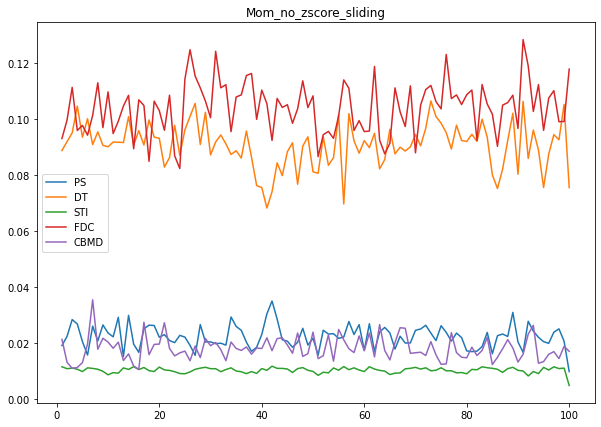

In [47]:
# Plot entropy high 1 no z score
x=range(1,101)
plt.figure(figsize=(10,7))
plt.title("Mom_no_zscore_sliding")
plt.plot(x,viol_PS_sl)
plt.plot(x,viol_DT_sl)
plt.plot(x,viol_STI_sl)
plt.plot(x,viol_FDC_sl)
plt.plot(x,viol_CBMD_sl)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Mom_high_no_z_score_sliding.png")
plt.show()

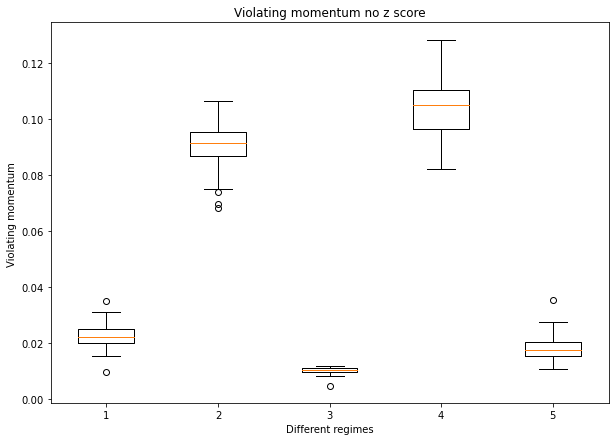

In [175]:
viol_high=[viol_PS_sl,viol_DT_sl,viol_STI_sl,viol_FDC_sl,viol_CBMD_sl]
fig = plt.figure(figsize =(10, 7))
plt.title("Violating momentum no z score")
plt.ylabel("Violating momentum ")
plt.xlabel("Different regimes")
plt.boxplot(viol_high)
plt.savefig("Box_plot_Viol_mom_high_no_zscore.png")
plt.show()

In [152]:
f_stat_an,p_an= stats.f_oneway(viol_PS_sl,viol_DT_sl,viol_STI_sl,viol_FDC_sl,viol_CBMD_sl)
print(p_an)

stat_k,p_k=stats.kruskal(viol_PS_sl,viol_DT_sl,viol_STI_sl,viol_FDC_sl,viol_CBMD_sl)
print(p_k)


# komologrov smirnov

#t_stat_t, p_t= stats.ttest_ind(viol_PS_sl,viol_DT_sl,viol_STI_sl,viol_FDC_sl,viol_CBMD_sl)
#print(p_t)

#U1, p_mann = mannwhitneyu(viol_PS_sl,viol_DT_sl,viol_STI_sl,viol_FDC_sl,viol_CBMD_sl, method="exact")
#print(p_mann)

0.0
7.779876642434488e-96


In [36]:
from numpy.fft import fft,ifft

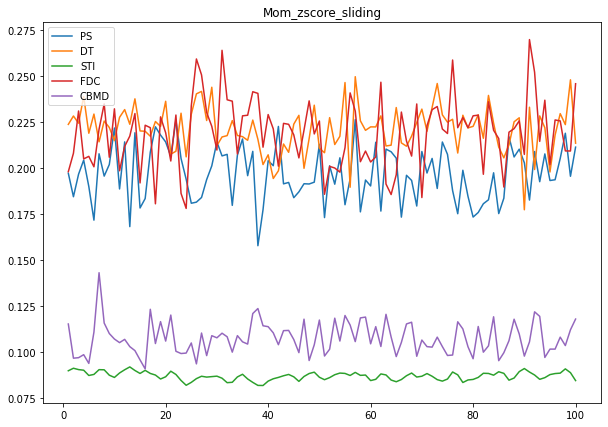

In [37]:
# Plot entropy high 1 no z score
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Mom_zscore_sliding")
plt.plot(x,viol_PS_z_sl)
plt.plot(x,viol_DT_z_sl)
plt.plot(x,viol_STI_z_sl)
plt.plot(x,viol_FDC_z_sl)
plt.plot(x,viol_CBMD_z_sl)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Mom_zscore_sliding.png")
plt.show()

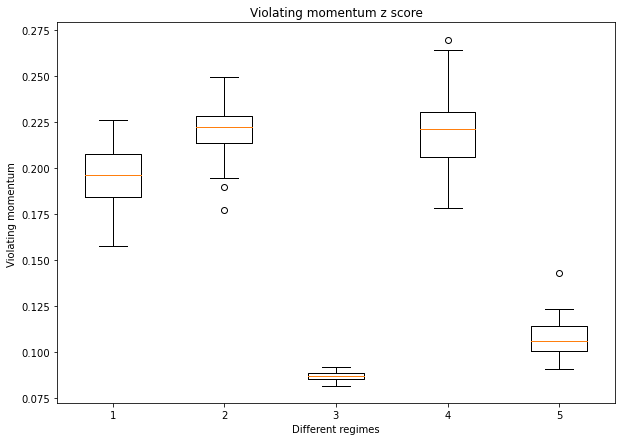

In [176]:
viol_high_z=[viol_PS_z_sl,viol_DT_z_sl,viol_STI_z_sl,viol_FDC_z_sl,viol_CBMD_z_sl]
fig = plt.figure(figsize =(10, 7))
plt.title("Violating momentum z score")
plt.ylabel("Violating momentum ")
plt.xlabel("Different regimes")
plt.boxplot(viol_high_z)
plt.savefig("Box_plot_Viol_mom_high_zscore.png")
plt.show()

In [151]:
f_stat_an, p_an = stats.f_oneway(viol_PS_z_sl,viol_DT_z_sl,viol_STI_z_sl,viol_FDC_z_sl,viol_CBMD_z_sl)
print(p_an)

stat_k,p_k=stats.kruskal(viol_PS_z_sl,viol_DT_z_sl,viol_STI_z_sl,viol_FDC_z_sl,viol_CBMD_z_sl)
print(p_k)

#t_stat_t, p_t= stats.ttest_ind(viol_PS_z_sl,viol_DT_z_sl,viol_STI_z_sl,viol_FDC_z_sl,viol_CBMD_z_sl)
#print(p_t)

#U1, p_mann = mannwhitneyu(viol_PS_z_sl,viol_DT_z_sl,viol_STI_z_sl,viol_FDC_z_sl,viol_CBMD_z_sl, method="exact")
#print(p_mann)

0.0
7.192942150567523e-90


In [99]:
# Sliding window




# Entropy COFL


length=120
indifference_value=0.05

#no zscore
hyp_PS_sl_cofl,en_1_PS_sl_cofl,en_0_PS_sl_cofl=en_h_hyp_v_sliding_cofl(ts_PS,length) 
hyp_DT_sl_cofl,en_1_DT_sl_cofl,en_0_DT_sl_cofl=en_h_hyp_v_sliding_cofl(ts_DT,length)   
hyp_STI_sl_cofl,en_1_STI_sl_cofl,en_0_STI_sl_cofl=en_h_hyp_v_sliding_cofl(ts_STI,length)
hyp_FDC_sl_cofl,en_1_FDC_sl_cofl,en_0_FDC_sl_cofl=en_h_hyp_v_sliding_cofl(ts_FDC,length)
hyp_CBMD_sl_cofl,en_1_CBMD_sl_cofl,en_0_CBMD_sl_cofl=en_h_hyp_v_sliding_cofl(ts_CBMD,length)

# z score
ts_PS_z=zscore(ts_PS,axis=0)
hyp_PS_z_sl_cofl,en_1_PS_z_sl_cofl,en_0_PS_z_sl_cofl=en_h_hyp_v_sliding_cofl(ts_PS_z,length) 
ts_DT_z=zscore(ts_DT,axis=0)
hyp_DT_z_sl_cofl,en_1_DT_z_sl_cofl,en_0_DT_z_sl_cofl=en_h_hyp_v_sliding_cofl(ts_DT_z,length)    
ts_STI_z=zscore(ts_STI,axis=0)
hyp_STI_z_sl_cofl,en_1_STI_z_sl_cofl,en_0_STI_z_sl_cofl=en_h_hyp_v_sliding_cofl(ts_STI_z,length)
ts_FDC_z=zscore(ts_FDC,axis=0)
hyp_FDC_z_sl_cofl,en_1_FDC_z_sl_cofl,en_0_FDC_z_sl_cofl=en_h_hyp_v_sliding_cofl(ts_FDC_z,length)
ts_CBMD_z=zscore(ts_CBMD,axis=0)
hyp_CBMD_z_sl_cofl,en_1_CBMD_z_sl_cofl,en_0_CBMD_z_sl_cofl=en_h_hyp_v_sliding_cofl(ts_CBMD_z,length)

KeyboardInterrupt: 

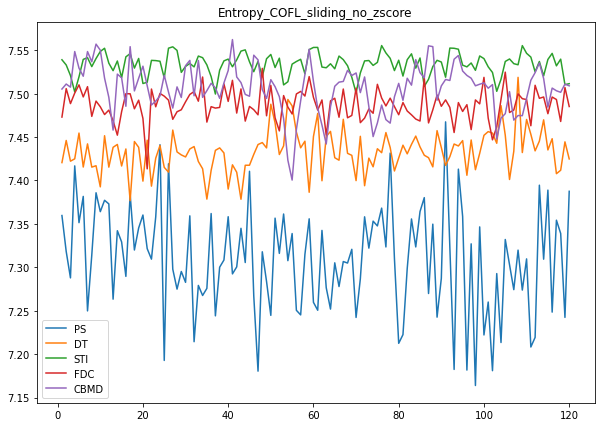

In [135]:
# Plot entropy Modified high 1 no z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Entropy_COFL_sliding_no_zscore")
plt.plot(x,en_1_PS_sl_cofl)
plt.plot(x,en_1_DT_sl_cofl)
plt.plot(x,en_1_STI_sl_cofl)
plt.plot(x,en_1_FDC_sl_cofl)
plt.plot(x,en_1_CBMD_sl_cofl)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Entropy_COFL_no_sliding_z_score.png")
plt.show()

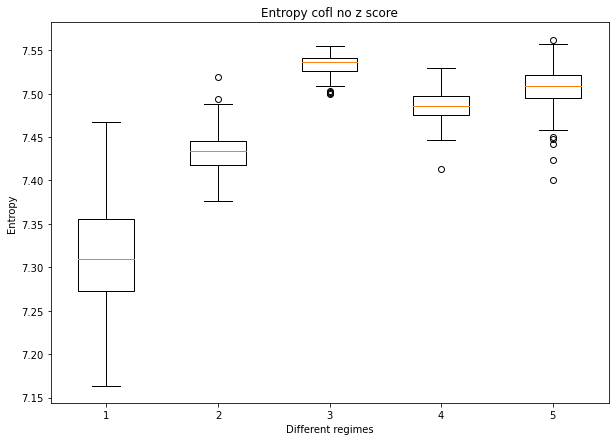

In [171]:
en_cofl=[en_1_PS_sl_cofl,en_1_DT_sl_cofl,en_1_STI_sl_cofl,en_1_FDC_sl_cofl,en_1_CBMD_sl_cofl]
fig = plt.figure(figsize =(10, 7))
plt.title("Entropy cofl no z score")
plt.ylabel("Entropy")
plt.xlabel("Different regimes")
plt.boxplot(en_cofl)
plt.savefig("Boxplot_entropy_cofl_no_zscore.png")
plt.show()

In [150]:
f_stat_an, p_an = stats.f_oneway(en_1_PS_sl_cofl,en_1_DT_sl_cofl,en_1_STI_sl_cofl,en_1_FDC_sl_cofl,en_1_CBMD_sl_cofl)
print(p_an)

stat_k,p_k=stats.kruskal(en_1_PS_sl_cofl,en_1_DT_sl_cofl,en_1_STI_sl_cofl,en_1_FDC_sl_cofl,en_1_CBMD_sl_cofl)
print(p_k)



#t_stat_t, p_t= stats.ttest_ind()
#print(p_t)

#U1, p_mann = mannwhitneyu()
#print(p_mann)

8.555618583407986e-246
1.0680701587819024e-109


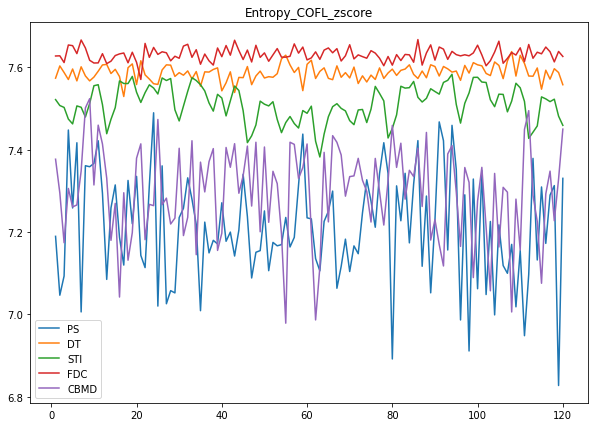

In [138]:
# Plot entropy 1  Modified high z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Entropy_COFL_zscore")
plt.plot(x,en_1_PS_z_sl_cofl)
plt.plot(x,en_1_DT_z_sl_cofl)
plt.plot(x,en_1_STI_z_sl_cofl)
plt.plot(x,en_1_FDC_z_sl_cofl)
plt.plot(x,en_1_CBMD_z_sl_cofl)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Entropy_COFL_sliding_z_score.png")
plt.show()

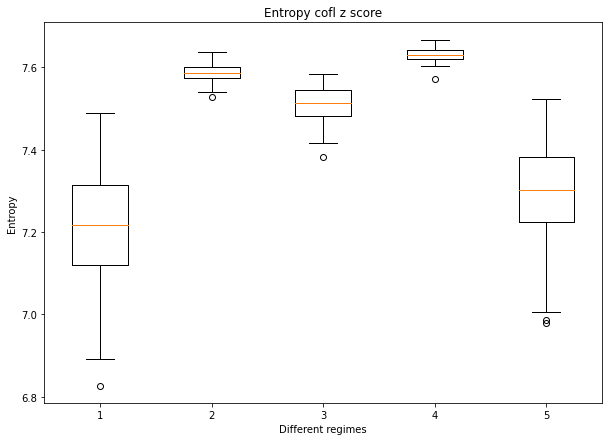

In [172]:
en_cofl_z=[en_1_PS_z_sl_cofl,en_1_DT_z_sl_cofl,en_1_STI_z_sl_cofl,en_1_FDC_z_sl_cofl,en_1_CBMD_z_sl_cofl]
fig = plt.figure(figsize =(10, 7))
plt.title("Entropy cofl z score")
plt.ylabel("Entropy")
plt.xlabel("Different regimes")
plt.boxplot(en_cofl_z)
plt.savefig("Boxplot_entropy_cofl_zscore.png")
plt.show()

In [149]:
f_stat_an, p_an = stats.f_oneway(en_1_PS_z_sl_cofl,en_1_DT_z_sl_cofl,en_1_STI_z_sl_cofl,en_1_FDC_z_sl_cofl,en_1_CBMD_z_sl_cofl)
print(p_an)

stat_k,p_k=stats.kruskal(en_1_PS_z_sl_cofl,en_1_DT_z_sl_cofl,en_1_STI_z_sl_cofl,en_1_FDC_z_sl_cofl,en_1_CBMD_z_sl_cofl)
print(p_k)



#t_stat_t, p_t= stats.ttest_ind()
#print(p_t)

#U1, p_mann = mannwhitneyu()
#print(p_mann)

8.103122887432277e-212
2.866237679565778e-115


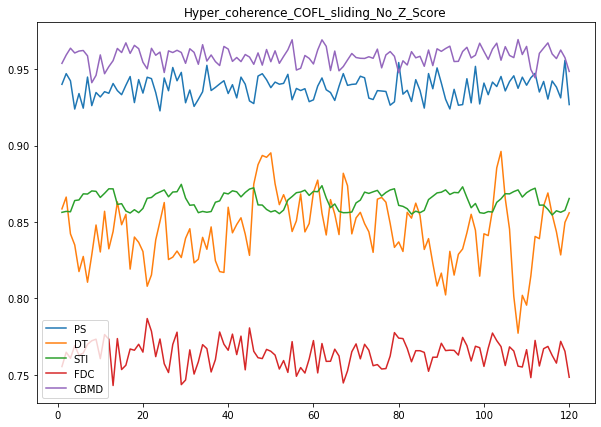

In [141]:
# plot hyper coherence COFL Sliding no z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Hyper_coherence_COFL_sliding_No_Z_Score")
plt.plot(x,hyp_PS_sl_cofl)
plt.plot(x,hyp_DT_sl_cofl)
plt.plot(x,hyp_STI_sl_cofl)
plt.plot(x,hyp_FDC_sl_cofl)
plt.plot(x,hyp_CBMD_sl_cofl)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Hyperocherence_sliding_COFL_no_zscore.png")
plt.show()

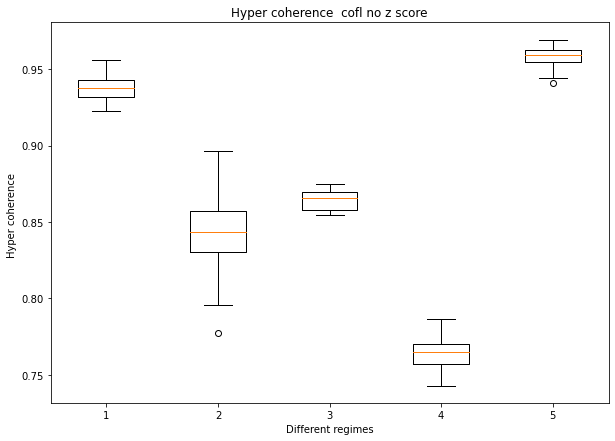

In [173]:
hyp_cofl=[hyp_PS_sl_cofl,hyp_DT_sl_cofl,hyp_STI_sl_cofl,hyp_FDC_sl_cofl,hyp_CBMD_sl_cofl]
fig = plt.figure(figsize =(10, 7))
plt.title("Hyper coherence  cofl no z score")
plt.ylabel("Hyper coherence ")
plt.xlabel("Different regimes")
plt.boxplot(hyp_cofl)
plt.savefig("Boxplot_Hypercoherence_cofl_no_zscore.png")
plt.show()

In [143]:
f_stat_an, p_an = stats.f_oneway(hyp_PS_sl_cofl,hyp_DT_sl_cofl,hyp_STI_sl_cofl,hyp_FDC_sl_cofl,hyp_CBMD_sl_cofl)
print(p_an)

stat_k,p_k=stats.kruskal(hyp_PS_sl_cofl,hyp_DT_sl_cofl,hyp_STI_sl_cofl,hyp_FDC_sl_cofl,hyp_CBMD_sl_cofl)
print(p_k)


#t_stat_t, p_t= stats.ttest_ind()
#print(p_t)

#U1, p_mann = mannwhitneyu()
#print(p_mann)

0.0


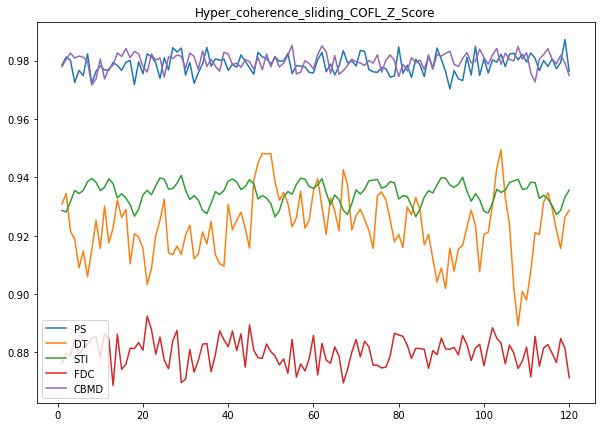

In [144]:
# plot hyper coherence Modified no z score
x=range(1,121)
plt.figure(figsize=(10,7))
plt.title("Hyper_coherence_sliding_COFL_Z_Score")
plt.plot(x,hyp_PS_z_sl_cofl)
plt.plot(x,hyp_DT_z_sl_cofl)
plt.plot(x,hyp_STI_z_sl_cofl)
plt.plot(x,hyp_FDC_z_sl_cofl)
plt.plot(x,hyp_CBMD_z_sl_cofl)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Hyperocherence_sliding_COFL_zscore.png")
plt.show()

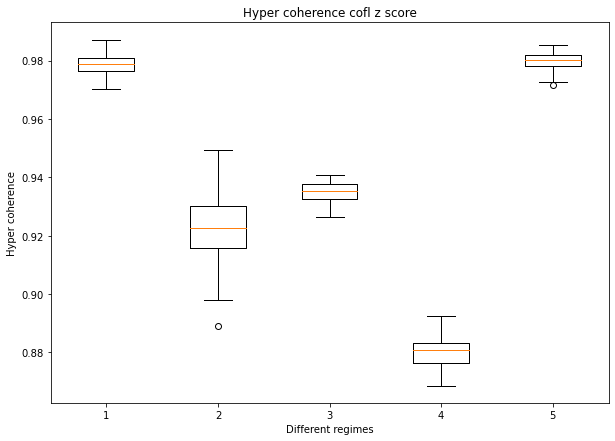

In [174]:
hyp_cofl_z=[hyp_PS_z_sl_cofl,hyp_DT_z_sl_cofl,hyp_STI_z_sl_cofl,hyp_FDC_z_sl_cofl,hyp_CBMD_z_sl_cofl]
fig = plt.figure(figsize =(10, 7))
plt.title("Hyper coherence cofl z score")
plt.ylabel("Hyper coherence")
plt.xlabel("Different regimes")
plt.boxplot(hyp_cofl_z)
plt.savefig("Boxplot_Hyper_coherence_cofl_zscore.png")
plt.show()

In [148]:
f_stat_an, p_an = stats.f_oneway(hyp_PS_z_sl_cofl,hyp_DT_z_sl_cofl,hyp_STI_z_sl_cofl,hyp_FDC_z_sl_cofl,hyp_CBMD_z_sl_cofl)
print(p_an)


stat_k,p_k=stats.kruskal(hyp_PS_z_sl_cofl,hyp_DT_z_sl_cofl,hyp_STI_z_sl_cofl,hyp_FDC_z_sl_cofl,hyp_CBMD_z_sl_cofl)
print(p_k)

#t_stat_t, p_t= stats.ttest_ind()
#print(p_t)

#U1, p_mann = mannwhitneyu()
#print(p_mann)

0.0
4.396954231154249e-114
